In [2]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn import preprocessing

     ---------------------------------------- 0.0/48.7 kB ? eta -:--:--
     ---------------------------------------- 48.7/48.7 kB 2.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/385.2 MB ? eta -:--:--
   ---------------------------------------- 0.2/385.2 MB 6.9 MB/s eta 0:00:56
   ---------------------------------------- 0.4/385.2 MB 6.9 MB/s eta 0:00:56
   ---------------------------------------- 0.6/385.2 MB 6.4 MB/s eta 0:01:00
   ---------------------------------------- 0.8/385.2 MB 5.7 MB/s eta 0:01:08
   ---------------------------------------- 1.1/385.2 MB 6.1 MB/s eta 0:01:04
   ---------------------------------------- 1.1/385.2 MB 6.1 MB/s eta 0:01:04
   ---------------------------------------- 1.3/385.2 MB 4.3 MB/s eta 0:01:29
   ---------------------------------------- 1.6/385.2 MB 4.7 MB/s eta 0:01:22
   ---------------------------------------- 1.8/385.2 MB 4.7 MB/s eta 0:01:23
   ---------------------------------------- 2.0/385.2 MB 4.8 MB/s eta 0:01:

In [4]:
df = pd.read_csv('wustl-ehms-2020_with_attacks_categories (2).csv')

In [5]:
df.head()

,Dir,Flgs,SrcAddr,DstAddr,Sport,Dport,SrcBytes,DstBytes,SrcLoad,DstLoad,...,Temp,SpO2,Pulse_Rate,SYS,DIA,Heart_rate,Resp_Rate,ST,Attack Category,Label
0,->,e,10.0.1.172,10.0.1.150,58059,1111,496,186,276914.0,92305.0,...,28.9,0,0,0,0,0,0,0.0,normal,0
1,->,e,10.0.1.172,10.0.1.150,58062,1111,496,186,230984.0,76995.0,...,28.9,0,0,0,0,78,17,0.4,normal,0
2,->,e,10.0.1.172,10.0.1.150,58065,1111,496,186,218470.0,72823.0,...,28.9,89,104,0,0,78,17,0.4,normal,0
3,->,e,10.0.1.172,10.0.1.150,58067,1111,496,186,203376.0,67792.0,...,28.9,89,104,0,0,79,17,0.4,normal,0
4,->,e,10.0.1.172,10.0.1.150,58069,1111,496,186,235723.0,78574.0,...,28.9,89,101,0,0,79,17,0.4,normal,0


In [6]:
df=df.drop(['Sport', 'Flgs', 'Packet_num', 'SrcGap', 'DstGap', 'DIntPktAct', 'dMinPktSz', 'Trans','Attack Category',
           'SrcMac', 'DstMac', 'SrcAddr', 'DstAddr', 'Dir'], axis =1)

print(df.shape)

(16318, 31)


In [7]:
df['Label'].value_counts()

Label
0    14272
1     2046
Name: count, dtype: int64

In [8]:
df.columns

Index(['Dport', 'SrcBytes', 'DstBytes', 'SrcLoad', 'DstLoad', 'SIntPkt',
       'DIntPkt', 'SIntPktAct', 'SrcJitter', 'DstJitter', 'sMaxPktSz',
       'dMaxPktSz', 'sMinPktSz', 'Dur', 'TotPkts', 'TotBytes', 'Load', 'Loss',
       'pLoss', 'pSrcLoss', 'pDstLoss', 'Rate', 'Temp', 'SpO2', 'Pulse_Rate',
       'SYS', 'DIA', 'Heart_rate', 'Resp_Rate', 'ST', 'Label'],
      dtype='object')

This is a Generative Adversarial Network (GAN). It is used to create synthetic records within a dataset. A GAN has two parts, a generator and a discriminator. The generator, generates the fake records and their class labels. The discriminator tries to prove that these fake records are fake by using the real records from the dataset. The model iterates, and the generator makes fake records until it can fool the discriminator. Those fake records can the be used in the dataset. 

This works especially well when using classification models. If I have a dataset with 70% of one class and only 30% of another class. I can use the GAN to make those missing 40% of the second class which will remove any bias in classification.

In [19]:
# Load dataset
X = df.drop(['Label'], axis=1)
Y = df['Label']

# Normalize the data
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Convert data to pandas DataFrame
real_data = pd.DataFrame(X, columns=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14',
                                    '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27',
                                    '28', '29', '30'])
real_labels = Y

# One hot encode labels
one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_labels = one_hot_encoder.fit_transform(np.array(real_labels).reshape(-1, 1))
print("One-hot labels shape:", one_hot_labels.shape)
print(one_hot_labels)

# Constants
NOISE_DIM = 100
NUM_CLASSES = 2
NUM_FEATURES = 30
BATCH_SIZE = 64
TRAINING_STEPS = 5000

# Generator
def create_generator():
    noise_input = Input(shape=(NOISE_DIM,))
    class_input = Input(shape=(NUM_CLASSES,))
    merged_input = Concatenate()([noise_input, class_input])
    hidden = Dense(128, activation='relu')(merged_input)
    output = Dense(NUM_FEATURES, activation='linear')(hidden)
    model = Model(inputs=[noise_input, class_input], outputs=output)
    return model

# Discriminator
def create_discriminator():
    data_input = Input(shape=(NUM_FEATURES,))
    class_input = Input(shape=(NUM_CLASSES,))
    merged_input = Concatenate()([data_input, class_input])
    hidden = Dense(128, activation='relu')(merged_input)
    output = Dense(1, activation='sigmoid')(hidden)
    model = Model(inputs=[data_input, class_input], outputs=output)
    return model

# cGAN
def create_cgan(generator, discriminator):
    noise_input = Input(shape=(NOISE_DIM,))
    class_input = Input(shape=(NUM_CLASSES,))
    generated_data = generator([noise_input, class_input])
    validity = discriminator([generated_data, class_input])
    model = Model(inputs=[noise_input, class_input], outputs=validity)
    return model

# Create and compile the Discriminator
discriminator = create_discriminator()

# Create the Generator
generator = create_generator()

# Create the GAN
gan = create_cgan(generator, discriminator)

# Ensure that only the generator is trained
discriminator.trainable = False

discriminator.compile(loss='binary_crossentropy', optimizer=Adam())
gan.compile(loss='binary_crossentropy', optimizer=Adam())

# Generate instances for a given class
def generate_data(generator, data_class, num_instances):
    one_hot_class = one_hot_encoder.transform(np.array([[data_class]]))
    noise = np.random.normal(0, 1, (num_instances, NOISE_DIM))
    generated_data = generator.predict([noise, np.repeat(one_hot_class, num_instances, axis=0)])
    return pd.DataFrame(generated_data, columns=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14',
                                    '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27',
                                    '28', '29', '30'])
# Train GAN
step_list = []
loss_list_discriminator = []
loss_list_generator = []
for step in range(TRAINING_STEPS):
    # Select a random batch of real data with labels
    idx = np.random.randint(0, real_data.shape[0], BATCH_SIZE)
    real_batch = real_data.iloc[idx].values
    labels_batch = one_hot_labels[idx]

    print("Real batch shape:", real_batch.shape)
    print("Labels batch shape:", labels_batch.shape)

    # Check if the input structure matches
    print("Inputs to discriminator:", [real_batch, labels_batch])

    # Generate a batch of new data
    noise = np.random.normal(0, 1, (BATCH_SIZE, NOISE_DIM))
    generated_batch = generator.predict([noise, labels_batch])

    # Train the discriminator
    real_loss = discriminator.train_on_batch([real_batch, labels_batch], np.ones((BATCH_SIZE, 1)))
    fake_loss = discriminator.train_on_batch([generated_batch, labels_batch], np.zeros((BATCH_SIZE, 1)))
    discriminator_loss = 0.5 * np.add(real_loss, fake_loss)

    # Train the generator
    generator_loss = gan.train_on_batch([noise, labels_batch], np.ones((BATCH_SIZE, 1)))

    if step % 50 == 0:
        print(f"Step: {step}, Discriminator Loss: {discriminator_loss}, Generator Loss: {generator_loss}")

    if step % 500 == 0:
        generated_samples = generate_data(generator, 1, 10)  # Change class as needed
        plt.figure(figsize=(10, 5))
        plt.scatter(generated_samples.iloc[:, 0], generated_samples.iloc[:, 1])  # Change to relevant columns
        plt.title(f"Generated Samples at Step {step}")
        plt.show()
    
    step_list.append(step)
    loss_list_discriminator.append(discriminator_loss)
    loss_list_generator.append(generator_loss)


# Generate 40 instances of class 1
generated_data = generate_data(generator, 1, 40)
print(generated_data)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(step_list, loss_list_discriminator)
plt.title('Discriminator Loss vs. Step')
    
plt.subplot(1,2,2)
plt.plot(step_list, loss_list_generator)
plt.title('Generator Loss vs. Step')

One-hot labels shape: (16318, 2)
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]
Real batch shape: (64, 30)
Labels batch shape: (64, 2)
Inputs to discriminator: [array([[0.        , 0.09356137, 0.08661417, ..., 0.68907563, 0.23287671,
        0.4       ],
       [0.        , 0.09356137, 0.08661417, ..., 0.49579832, 0.97260274,
        0.35384615],
       [0.        , 0.09356137, 0.08661417, ..., 0.61344538, 0.26027397,
        0.46153846],
       ...,
       [0.        , 0.09356137, 0.08661417, ..., 0.58823529, 0.26027397,
        0.33846154],
       [0.        , 0.09356137, 0.08661417, ..., 0.66386555, 0.24657534,
        0.33846154],
       [0.        , 0.09356137, 0.08661417, ..., 0.61344538, 0.26027397,
        0.46153846]]), array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1.

c:\Users\trush\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_117', 'keras_tensor_118']. Received: the structure of inputs=('*', '*')
  warnings.warn(


AttributeError: 'NoneType' object has no attribute 'update_state'

Text(0.5, 1.0, 'Generator Loss vs. Step')

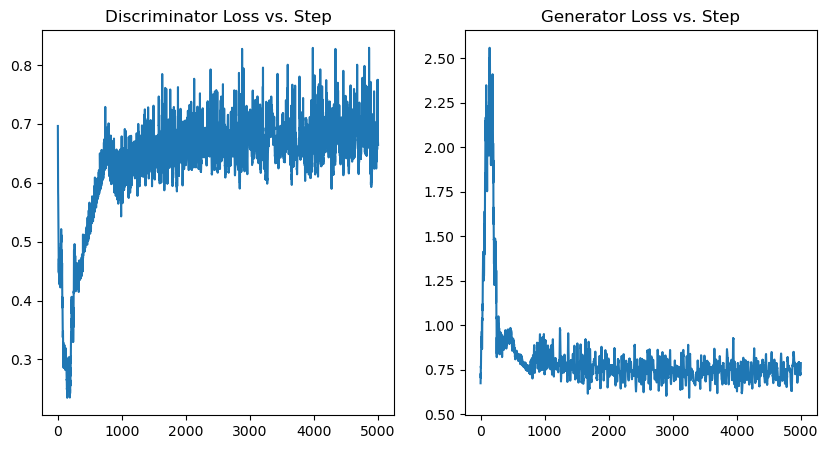

In [25]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(step_list, loss_list_discriminator)
plt.title('Discriminator Loss vs. Step')
    
plt.subplot(1,2,2)
plt.plot(step_list, loss_list_generator)
plt.title('Generator Loss vs. Step')

In [26]:
synthetic_data_class_1 = generate_data(generator, 1, 12226)

383/383 [==============================] - 0s 684us/step


In [29]:
synthetic_data = synthetic_data_class_1
synthetic_data = pd.DataFrame(scaler.inverse_transform(synthetic_data), 
                              columns=['Dport', 'SrcBytes', 'DstBytes', 'SrcLoad', 'DstLoad', 'SIntPkt',
       'DIntPkt', 'SIntPktAct', 'SrcJitter', 'DstJitter', 'sMaxPktSz',
       'dMaxPktSz', 'sMinPktSz', 'Dur', 'TotPkts', 'TotBytes', 'Load', 'Loss',
       'pLoss', 'pSrcLoss', 'pDstLoss', 'Rate', 'Temp', 'SpO2', 'Pulse_Rate',
       'SYS', 'DIA', 'Heart_rate', 'Resp_Rate', 'ST'])

synthetic_labels = [1]*12226
synthetic_data['Label'] = synthetic_labels
synthetic_data.to_csv('synthetic_attack_csv', index=False)

In [33]:
synthetic_data = pd.read_csv('synthetic_attack_csv.csv')
synthetic_data.head()

,Dport,SrcBytes,DstBytes,SrcLoad,DstLoad,SIntPkt,DIntPkt,SIntPktAct,SrcJitter,DstJitter,...,Rate,Temp,SpO2,Pulse_Rate,SYS,DIA,Heart_rate,Resp_Rate,ST,Label
0,1111.0082,457.49832,160.70564,144696.280,123811.93,-32.230392,-6.746273,6.346960,1048.7703,67.247260,...,758.58704,26.692019,93.83487,65.494770,138.24042,78.38708,78.169464,23.972712,0.133747,1
1,1111.0121,445.53696,151.47954,95598.410,181022.66,-252.328580,4.579193,28.192434,1623.6350,99.999710,...,907.10320,27.011578,98.90842,60.261566,146.75758,85.09257,82.289590,26.937397,0.161254,1
2,1111.0132,443.93433,157.71684,88482.305,177006.83,-215.850590,5.360202,16.299768,1750.0514,110.431050,...,908.93160,27.036568,99.36329,61.939133,148.06639,85.99902,83.181940,26.979069,0.174369,1
3,1111.0332,424.71603,168.65498,-56999.780,134394.64,-187.064250,52.662980,-24.065668,2297.9400,152.384220,...,601.34357,27.533875,104.65795,56.661720,153.29152,95.03060,91.046800,30.183187,0.249578,1
4,1111.0033,459.33840,156.48943,155612.720,157822.53,-104.848150,-1.383490,6.972915,1369.2805,67.138756,...,869.11960,26.686900,94.64989,64.273380,139.55432,78.72229,77.687065,24.847252,0.136899,1


In [34]:
df.head()

,Dport,SrcBytes,DstBytes,SrcLoad,DstLoad,SIntPkt,DIntPkt,SIntPktAct,SrcJitter,DstJitter,...,Rate,Temp,SpO2,Pulse_Rate,SYS,DIA,Heart_rate,Resp_Rate,ST,Label
0,1111,496,186,276914.0,92305.0,3.582333,1.9015,0.0,2.946239,1.6235,...,558.295,28.9,0,0,0,0,0,0,0.0,0
1,1111,496,186,230984.0,76995.0,4.294667,2.9015,0.0,3.091654,2.8625,...,465.694,28.9,0,0,0,0,78,17,0.4,0
2,1111,496,186,218470.0,72823.0,4.540667,3.2945,0.0,2.849841,3.1655,...,440.464,28.9,89,104,0,0,78,17,0.4,0
3,1111,496,186,203376.0,67792.0,4.877667,3.3320,0.0,2.452252,3.2570,...,410.032,28.9,89,104,0,0,79,17,0.4,0
4,1111,496,186,235723.0,78574.0,4.208333,2.8635,0.0,3.021835,2.8225,...,475.247,28.9,89,101,0,0,79,17,0.4,0


In [35]:
combined_data = pd.concat([df, synthetic_data], ignore_index=True)
combined_data.head()

,Dport,SrcBytes,DstBytes,SrcLoad,DstLoad,SIntPkt,DIntPkt,SIntPktAct,SrcJitter,DstJitter,...,Rate,Temp,SpO2,Pulse_Rate,SYS,DIA,Heart_rate,Resp_Rate,ST,Label
0,1111.0,496.0,186.0,276914.0,92305.0,3.582333,1.9015,0.0,2.946239,1.6235,...,558.295,28.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,1111.0,496.0,186.0,230984.0,76995.0,4.294667,2.9015,0.0,3.091654,2.8625,...,465.694,28.9,0.0,0.0,0.0,0.0,78.0,17.0,0.4,0
2,1111.0,496.0,186.0,218470.0,72823.0,4.540667,3.2945,0.0,2.849841,3.1655,...,440.464,28.9,89.0,104.0,0.0,0.0,78.0,17.0,0.4,0
3,1111.0,496.0,186.0,203376.0,67792.0,4.877667,3.3320,0.0,2.452252,3.2570,...,410.032,28.9,89.0,104.0,0.0,0.0,79.0,17.0,0.4,0
4,1111.0,496.0,186.0,235723.0,78574.0,4.208333,2.8635,0.0,3.021835,2.8225,...,475.247,28.9,89.0,101.0,0.0,0.0,79.0,17.0,0.4,0


In [36]:
combined_data['Label'].value_counts()

Label
0    14272
1    14272
Name: count, dtype: int64

In [37]:
#Running a Classifier on the combined dataset

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_predict

X = combined_data.drop('Label', axis=1)
y = combined_data['Label']

lr = LogisticRegression()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lr.fit(X_train, y_train)

y_pred = cross_val_predict(lr, X, y, cv=5)

print('The Accuracy of this model is: ', accuracy_score(y, y_pred))
print('Confusion Matrix')
print(confusion_matrix(y, y_pred))

C:\Users\trush\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\trush\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

The Accuracy of this model is:  0.9253783632286996
Confusion Matrix
[[14187    85]
 [ 2045 12227]]


C:\Users\trush\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\trush\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_